In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sklearn
import shapely.wkt
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
import hdbscan # new clustering algorithm
import mplleaflet
from scipy.spatial.distance import pdist, squareform, euclidean, directed_hausdorff
from haversine import haversine


%matplotlib inline

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

In [3]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)
mtl_greater = mtl_greater.dissolve(by="CMANAME")

In [4]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.dropna(subset=['mode'])
gdf = gdf.reset_index(drop=True)

In [5]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [6]:
gdf['log_dur'] = np.log(gdf.seconds+1)
gdf['log_dist'] = np.log(gdf.distance_m+1)

## new purpose classifications

In [7]:
new_classifications = {"1":["shops","leisure","cafe","returning_home"],"2":["education"],\
                       "3":["health"],"4":["pick_up_a_person"],"5":["work"]}

In [8]:
def new_pur_labels(row, purpose_label_dict=new_classifications):
    for key, val in purpose_label_dict.items():
        if row.purpose in val:
            return key

    return None

In [9]:
gdf['purpose_labels'] = gdf.apply(new_pur_labels, axis=1)

In [10]:
gdf.purpose_labels.value_counts()

1    47464
5    18950
2     2769
4     1574
3     1044
Name: purpose_labels, dtype: int64

In [11]:
gdf = gdf.dropna(subset=["purpose_labels"])

In [12]:
## get all the purposes and modes above 1000 trips
above1000_purpose = gdf.groupby(['purpose']).count()['id_trip'][gdf.groupby(['purpose']).count()['id_trip'] > 1000].index
above1000_mode = gdf.groupby(['mode']).count()['id_trip'][gdf.groupby(['mode']).count()['id_trip'] > 1000].index
ordered_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [13]:
mtl_land_use = gpd.read_file('../data/mtl_land_use.json')

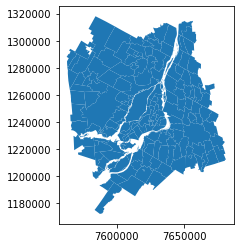

In [14]:
mtl_region.plot()
# plt.savefig("a_test.png")

## Variable preparation

In [14]:
# convert the point columns back into a Point class
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

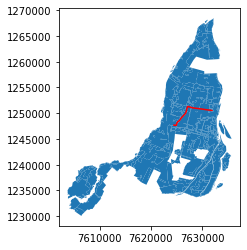

In [40]:
fig, ax = plt.subplots(1)
mtl_land_use.plot(ax=ax)
gdf.loc[0:0].plot(ax=ax, color='r')


In [107]:
%%time
## 25 mins
def intersect_landuse(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.start_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"
    
def intersect_landuse_end(row):
    try:
        the_cat = mtl_land_use.iloc[np.where(mtl_land_use.intersects(shapely.geometry.Point(row.end_can)))[0]].categorie
        return the_cat.values[0]
    except:
        return "0"
gdf['land_use_start'] = gdf.apply(intersect_landuse, axis=1)
gdf['land_use_end'] = gdf.apply(intersect_landuse_end, axis=1)

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7603779.4718526863 1234964.8369353164 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1

TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0
TopologyException: side location conflict at 7626699.4429327119 1246601.0258739288 0


CPU times: user 25min 2s, sys: 9.43 s, total: 25min 12s
Wall time: 25min 26s


In [109]:
gdf.land_use_start.value_counts()

residential               33628
mixed                     18164
0                          9582
employment                 3862
institution                2611
diversified activities     2070
park                       1478
conservation                157
religious                   148
infrastructure              101
Name: land_use_start, dtype: int64

In [110]:
gdf.land_use_end.value_counts()

residential               35154
mixed                     18152
0                          9187
employment                 3218
institution                3186
diversified activities     1843
park                        789
religious                   133
conservation                102
infrastructure               37
Name: land_use_end, dtype: int64

In [112]:
gdf.groupby(["land_use_start","land_use_end", "purpose"]).agg({"purpose":"count"})

purpose
land_use_start land_use_end purpose                  
0              0            cafe                  210
                            education             124
                            health                 90
                            leisure               810
                            pick_up_a_person      173
...                                               ...
residential    residential  leisure              2569
                            pick_up_a_person      630
                            returning_home       8854
                            shops                2097
                            work                 3237

[503 rows x 1 columns]

In [117]:
gdf['trip_durations'] = round(gdf.seconds / 360)

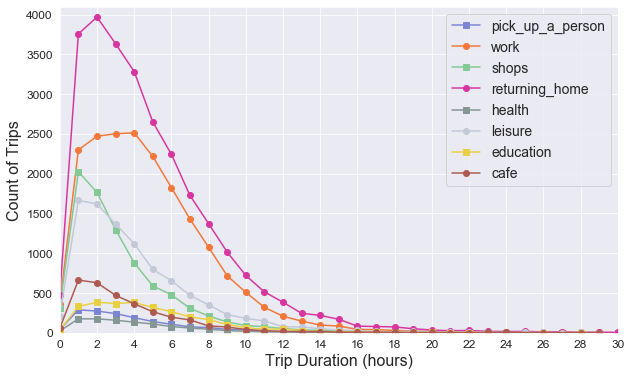

In [324]:
gdf_trip_durations_per_purpose = gdf.groupby(['purpose','trip_durations']).agg({'seconds':'count'}).reset_index()
colorblind_pallette = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
fig, ax = plt.subplots(1, figsize=(10,6))
counter = 0
for pur, c in zip(gdf.purpose.unique(), colorblind_pallette):
    if counter % 2 == 0:
        gdf_trip_durations_per_purpose.loc[gdf_trip_durations_per_purpose.purpose == pur].set_index('trip_durations').seconds.plot(marker='s', color=c, ax=ax)
    else:
        gdf_trip_durations_per_purpose.loc[gdf_trip_durations_per_purpose.purpose == pur].set_index('trip_durations').seconds.plot(marker='o', color=c, ax=ax)
    plt.legend([pur for pur in gdf.purpose.unique()], fontsize=14)
    plt.ylim(0,4100)
    plt.xticks(np.arange(0,31,2), size=12)
    plt.yticks(size=12)
    plt.xlabel("Trip Duration (hours)", size=16)
    plt.ylabel("Count of Trips", size=16)
    counter += 1
# plt.savefig("figures/average_trip_duration_per_purpose.png", bbox_inches='tight')

In [210]:
literature_review_model_comparison = pd.read_csv("../../MSc_Dissertation/write_up/other_figures/literature_review_comparison_models.csv")

array(['Bohte & Matt (2009)', 'Alsger et al. (2018)',
       'Oliveira et al. (2014)', 'Xiao et al. (2016)',
       'Montini et al. (2014)', 'Kim et al. (2014)',
       '\ufeffErmagun et al. (2017)', 'Yazdizadeh et al. (2019)',
       'Zhu et al (2014)'], dtype=object)

In [211]:
literature_review_model_comparison

,Study,Work,Education,Shop,Home,Recreation/Leisure,Accuracy or Precision,Model
0,Bohte & Maat (2009),31.0,4.0,35.0,74.0,19.0,A,Rule
1,Alsger et al. (2018),85.0,16.0,19.0,82.0,6.0,A,Rule
2,Oliveira et al. (2014),26.0,98.0,50.0,NaN,26.0,A,Probabilistic
3,Xiao et al. (2016),98.4,98.4,93.6,99.2,NaN,P,ANN
4,Montini et al. (2014),85.1,85.1,62.6,99.3,69.3,P,RF
5,Kim et al. (2014),88.2,10.0,7.7,100.0,0.0,A,RF
6,Ermagun et al. (2017),NaN,92.2,58.4,NaN,62.5,P,RF
7,Yazdizadeh et al. (2019),78.9,73.2,67.4,68.0,71.4,P,RF
8,Zhu et al (2014),68.0,67.0,69.0,91.0,52.0,F1,SVM


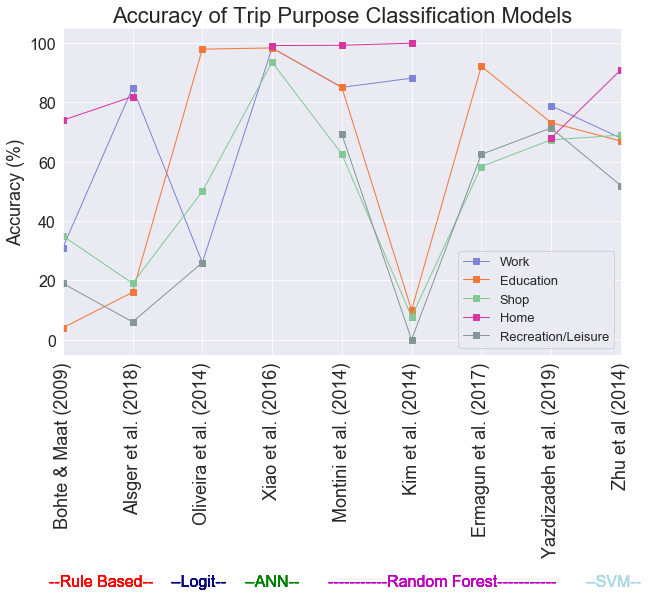

In [333]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, figsize=(10,6))
for i, c in zip(literature_review_model_comparison.columns[1:6], colorblind_pallette):
#     if i in ["Work"]
    literature_review_model_comparison[i].plot(marker='s', ax=ax, color=c, linewidth=1)
    ax.text(s="--Rule Based--", color='red', x=-.2, y=-83, size=16)
    ax.text(s="--Logit--", color='navy', x=1.55, y=-83, size=16)
    ax.text(s="--ANN--", color='green', x=2.6, y=-83, size=16)
    ax.text(s="-----------Random Forest-----------", color='m', x=3.8, y=-83, size=16)
    ax.text(s="--SVM--", color='lightblue', x=7.5, y=-83, size=16)
    ax.set_ylabel("Accuracy (%)", size=18)

#     ax.set_xlabel("Study", size=18)
    ax.set_xticklabels(labels=list(literature_review_model_comparison.Study.values), rotation=90, size=18);
plt.legend(fontsize=13)
plt.yticks(size=16)
plt.title("Accuracy of Trip Purpose Classification Models", size=22)
# plt.savefig("../../MSc_Dissertation/write_up/other_figures/classification_model_lit_review.png", bbox_inches='tight')

## Cluster

In [342]:
gdf['startx'] = gdf.start_can.apply(lambda row: row.x)
gdf['starty'] = gdf.start_can.apply(lambda row: row.y)
gdf['endx'] = gdf.end_can.apply(lambda row: row.x)
gdf['endy'] = gdf.end_can.apply(lambda row: row.y)

In [343]:
# Calculate DISTANCE MATRIX
coords_st = [[x,y] for x, y in zip(gdf['startx'], gdf['starty'])]
coords_en = [[x,y] for x, y in zip(gdf['endx'], gdf['endy'])]

In [344]:
# get a list of all end-points for clustering algorithm
overall_coords = coords_st
overall_coords.extend(coords_en)

In [345]:
len(overall_coords)

143602

In [20]:
# %%time
# Run the Kmeans algorithm and get the index of data points clusters
# sse = []
# list_k = list(range(1, 25))

# for k in list_k:
#     km = KMeans(n_clusters=k)
#     km.fit(overall_coords)
#     sse.append(km.inertia_)

In [21]:
# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(range(1,len(sse)+1), sse, '-o')
# plt.axvline(6,0,1, linestyle='--', color='k')
# plt.xlabel(r'Number of clusters *k*', size=18)
# plt.ylabel('Sum of squared distance', size=18);
# plt.savefig('figures/elbowplot_kmeans.png', bbox_inches='tight')

In [86]:
# pd.DataFrame(sse).to_csv("analysis_results/kmean_sse.csv", index=False)
sse = pd.read_csv("analysis_results/kmean_sse.csv")
sse['num_clusters'] = np.arange(2, 51)

In [78]:
sns.set_style("dark")

In [94]:
np.arange(2,len(sse)+2)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

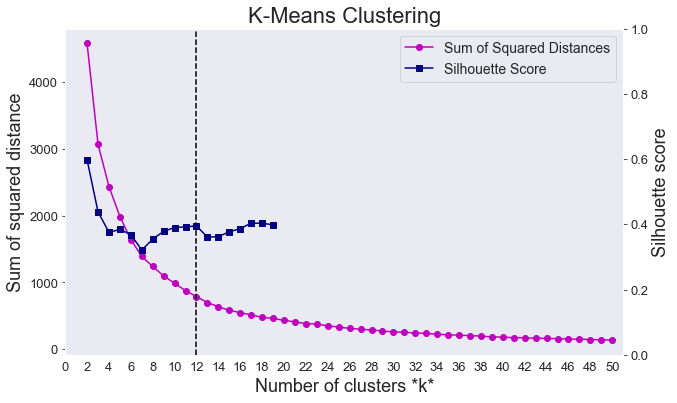

<Figure size 432x432 with 0 Axes>

In [120]:
# Plot sse against k

fig, ax = plt.subplots(1, figsize=(10,6))
plt.figure(figsize=(6, 6))
ln1 = ax.plot(np.arange(2,len(sse)+2), sse.sse_clusters, '-o', color='m', label='Sum of Squared Distances')
ax.axvline(12,0,1, linestyle='--', color='k')
ax.set_xlabel(r'Number of clusters *k*', size=18)
ax.set_ylabel('Sum of squared distance', size=18);
ax2 = ax.twinx()
ln2 = ax2.plot(silh_scores.clusters, silh_scores.silhscore, color='navy', marker='s', label='Silhouette Score')
ax2.set_ylabel("Silhouette score",size=18)
ax.set_yticklabels(labels=[1, 0, 1000, 2000,3000,4000], size=13)
ax.set_xticks(np.arange(0,51, 2))
ax.set_xticklabels(labels=np.arange(0,51, 2), size=13)
ax2.set_ylim(0,1)
ax.set_xlim(0, 51)
ax2.set_yticklabels(labels=[round(i, 2) for i in np.arange(0,1.1, .2)], size=13)
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=14)
ax.set_title("K-Means Clustering", size=22)
# ax.figure.savefig('figures/elbowplot_kmeans_sum_silh.png', bbox_inches='tight')
plt.show()


In [346]:
%%time
kmeans = KMeans(n_clusters=12, random_state=0).fit(overall_coords)
kmeans.labels_

CPU times: user 7.39 s, sys: 1.05 s, total: 8.43 s
Wall time: 6.92 s


array([ 2,  8,  0, ...,  1,  0, 10], dtype=int32)

In [347]:
gdf['startclust'] = kmeans.labels_[:int(len(gdf))]
gdf['endclust'] = kmeans.labels_[int(len(gdf)):]

In [348]:
print(gdf.startclust.value_counts())
print(gdf.endclust.value_counts())

5     19069
0     18564
1     10295
10     9725
2      7082
9      1963
4      1837
3      1606
8       843
6       385
11      243
7       189
Name: startclust, dtype: int64
5     19750
0     18380
1      9861
10     9712
2      7076
9      2132
4      1783
3      1654
8       808
6       347
11      176
7       122
Name: endclust, dtype: int64


In [37]:
# %%time
# sihouette_scores = []
# # The silhouette_score gives the average value for all the samples.
# # This gives a perspective into the density and separation of the formed clusters
# for i in range(2,30):
#     print(i)
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(overall_coords)
#     sihouette_scores.append(silhouette_score(overall_coords, kmeans.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
CPU times: user 1h 13min 57s, sys: 15min 39s, total: 1h 29min 37s
Wall time: 1h 21min 24s


In [67]:
# silh_scores = pd.DataFrame([np.arange(2,20), sihouette_scores]).T
# silh_scores.columns = ['clusters','silhscore']
# silh_scores.to_csv("analysis_results/silhscores.csv", index=False)

In [19]:
silh_scores = pd.read_csv("analysis_results/silhscores.csv")

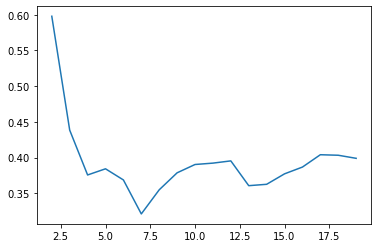

In [23]:
# The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
plt.plot(silh_scores.clusters, silh_scores.silhscore)

In [163]:
colorblind_pallette = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k","cyan",'pink']

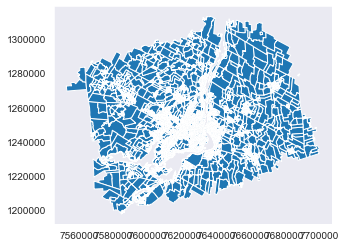

In [164]:
colorblind_pallette = cm.ListedColormap(colorblind_pallette)

In [191]:
sns.set_style('white')


In [213]:
import matplotlib.patches as mpatches

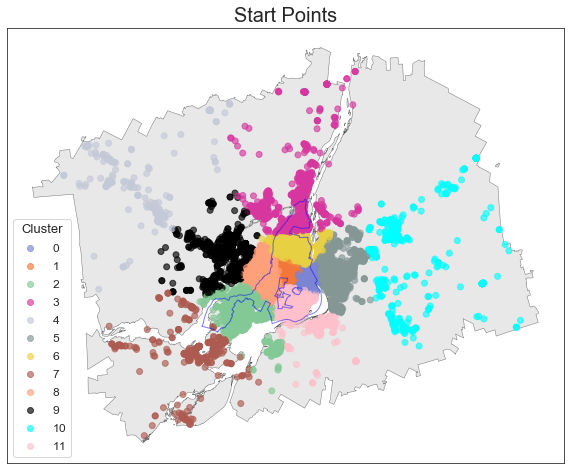

In [226]:
fig, ax = plt.subplots(1, figsize=(14, 8))
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='lightgrey', alpha=.5, linewidth=0.5, edgecolor='k')

scatter = ax.scatter(gdf.startx, gdf.starty, c=gdf.startclust, cmap=colorblind_pallette, alpha=.65)
city_of_montreal.dissolve(by="TYPE").plot(ax=ax, color=None, facecolor='none', edgecolor='blue', linewidth=1, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster", fontsize=12 )

plt.xticks([]); plt.yticks([]);
ax.set_title("Start Points", size=20)
legend1.set_title('Cluster',prop={'size':13})
# ax.figure.savefig("figures/kmeans_cluster_start.png", bbox_inches='tight')

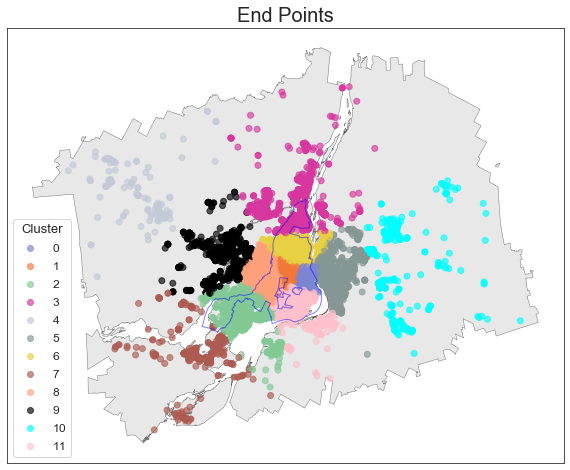

In [227]:
fig, ax = plt.subplots(1, figsize=(14, 8))
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='lightgrey', alpha=.5, linewidth=0.5, edgecolor='k')

scatter = ax.scatter(gdf.endx, gdf.endy, c=gdf.endclust, cmap=colorblind_pallette, alpha=.65)
city_of_montreal.dissolve(by="TYPE").plot(ax=ax, color=None, facecolor='none', edgecolor='blue', linewidth=1, alpha=.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster", fontsize=12 )

plt.xticks([]); plt.yticks([]);
ax.set_title("End Points", size=20)
legend1.set_title('Cluster',prop={'size':13})
# ax.figure.savefig("figures/kmeans_cluster_end.png", bbox_inches='tight')

In [ ]:
# pd.DataFrame(sse, columns=['sse_clusters']).to_csv("analysis_results/kmean_sse.csv", index=False)

## Subset by all, rush and city

In [29]:
new_column_labels = {"temporal_c":"Temporal Cluster Label","temperatur":"Temperature",\
                     "log_dist":'log(Distance)', "log_dur":'log(Duration)',\
                     "magnitude":'Directional magnitude', "precip":"Precipitation","carddir":'Direction',\
                     "mode":'Travel Mode', "endclust":'End Cluster Label',\
                     "startclust":'Start Cluster Label', "weekday":'Weekday?',\
                     "thrurush":'Through Rush Hour', "endrush":'End in Rush Hour',\
                     "startrush":'Start in Rush Hour', "end_downto":'End in City', "start_down":'Start in City'}




In [30]:
purp_gdf = gdf
purp_city = purp_gdf.loc[(purp_gdf.start_down == 1)|(purp_gdf.end_downto == 1)]
purp_noncity = purp_gdf.loc[(purp_gdf.start_down != 1)&(purp_gdf.end_downto != 1)]

purp_rush = purp_gdf.loc[(purp_gdf.startrush == 1)|(purp_gdf.endrush == 1)|(purp_gdf.thrurush == 1)]
purp_nonrush = purp_gdf.loc[(purp_gdf.startrush != 1)&(purp_gdf.endrush != 1)&(purp_gdf.thrurush != 1)]

In [324]:
from sklearn.model_selection import cross_val_score
def model_setup(data, norm=False):
    mode_factorise = pd.factorize(data['mode'])
    data['mode'] = pd.factorize(data['mode'])[0]
    data['carddir'] = pd.factorize(data['carddir'])[0]
    
    X = data[['id_trip',"mode","log_dur","log_dist","magnitude","carddir","start_down",\
          "end_downto","weekday", "temporal_c","precip","temperatur",\
        "startrush","endrush","thrurush","startclust","endclust"]]
    y = data[["purpose_labels"]]
    X.weekday = X.weekday.astype(int)
    feature_list = list(X.columns)
    
    if norm:
        X = normalise(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test, feature_list
    
def normalise(X):
    X = X / np.amax(X, axis=0)
    return X

def subset_to_imp_features(data, above_005):
    above_005.append("id_trip")
    data = data[data.columns[[col in above_005 for col in data.columns]]]
    return data
    

def run_rf(data, X_train=None, X_test=None, y_train=None, y_test=None, feature_list=None, norm=False, cv=False):
    if not X_train:
        X_train, X_test, y_train, y_test, feature_list = model_setup(data, norm=norm)
    clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)

    if cv:
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        print("Score:", scores)
    else:
        clf.fit(X_train, y_train)
        scores = clf.score(X_test,y_test)
        print("Score:", scores)
    return clf, feature_list, scores

def calc_feature_imp(clf, feature_list):
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    above_005 = [i[0] if i[1] >= 0.05 else "purpose_labels" for i in feature_importances]
    return feature_importances, above_005

def plot_feature_imp(feature_importances):    
    fig, ax = plt.subplots(1, figsize=(10,6))
    feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
    feat_imp.plot(kind='barh', ax=ax, legend=False)
    ax.set_yticklabels([new_column_labels[i] for i in list(feat_imp.importance.values)], size=16);
    plt.xticks(size=16);
    ax.set_xlim(0,0.35)
    ax.axvline(0.05, -10,40, color='r',linestyle='--')
    ax.set_xlabel("Feature Importance", size=20)
    ax.set_ylabel("Feature", size=20)
    ax.set_title("Random Forest Classification Feature Importance", size=22)
    return ax

def encode_inputs(data):
    non_code_columns = ["mode","carddir","startclust","endclust", "purpose_labels", "id_trip"]
    enc = OneHotEncoder(handle_unknown='ignore')
    mode_codes = np.array([])
    carddir_codes = np.array([])
    stcl_codes = np.array([])
    encl_codes = np.array([])
    if 'mode' in data.columns:
        mode_codes = enc.fit_transform(data['mode'].values.reshape(-1, 1)).toarray()
    elif 'carddir' in data.columns:
        carddir_codes = enc.fit_transform(data['carddir'].values.reshape(-1, 1)).toarray()
    elif 'startclust' in data.columns:
        stcl_codes = enc.fit_transform(data['startclust'].values.reshape(-1, 1)).toarray()
    elif 'endclust' in data.columns:
        encl_codes = enc.fit_transform(data['endclust'].values.reshape(-1, 1)).toarray()
    if 'weekday' in data.columns:
        data['weekday'] = data['weekday'].astype(int)
    y_codes = enc.fit_transform(data['purpose_labels'].values.reshape(-1, 1)).toarray()
    
    unique_ids = data['id_trip'].values.reshape(-1,1)
    non_codes = data[data.columns[[col not in non_code_columns for col in data.columns]]]
    
    feature_list = list(non_codes)
    non_codes = non_codes.values
    # normalise
    non_codes = non_codes / np.amax(non_codes, axis=0)
    other_inputs = {}
    # only return codes that are above 0.05 importance
    for i, cds in enumerate([non_codes, mode_codes, carddir_codes, stcl_codes, encl_codes, unique_ids]):
        if len(cds) != 0:
            other_inputs[i] = cds
    other_inputs = np.concatenate(tuple(other_inputs.values()), axis=1)
    return other_inputs, y_codes

def run_mcrf(all_input, y_codes, cv=False, X_train=None, X_test=None, y_train=None, y_test=None):
#     X = data[data.columns[[col != "purpose_labels" for col in data.columns]]]
#     y = data[data.columns[[col == "purpose_labels" for col in data.columns]]]
    if type(X_train) == None:
        X_train, X_test, y_train, y_test = train_test_split(all_input, y_codes, test_size=0.33, random_state=42)
    clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    multi_target_forest = MultiOutputClassifier(clf, n_jobs=-1)
    if cv:
        scores = cross_val_score(multi_target_forest, X_train, y_train, cv=5)
    else:
        multi_target_forest.fit(X_train, y_train)
        scores = multi_target_forest.score(X_test, y_test)
    preds = multi_target_forest.predict(X_test)
    return scores, preds

def run_svc(X_train, X_test, y_train, y_test, cv=False):
    clf = svm.SVC(gamma=0.01, C=0.1, decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    if cv:
        scores = cross_val_score(clf, X_train, y_train, cv=5)
    else:
        scores = clf.score(X_test, y_test)
    preds = clf.predict(X_test)  
    return scores, preds


def run_ann(X_train, X_test, y_train, y_test, cv=False):
    clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
    clf.fit(X_train, y_train)
    if cv:
        scores = cross_val_score(clf,X_train,y_train, cv=5)
    else:
        scores = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    
    return scores, preds

In [ ]:
# cv scores
rf_scores = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    clf, feature_list, scores = run_rf(df, norm=False, cv=True)
    rf_scores[df_name] = scores

In [47]:
# plot and save
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    clf, feature_list, scores = run_rf(df, norm=False, cv=False)
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    ax = plot_feature_imp(clf, feature_list)
#     ax.figure.savefig("figures/rf_feat_imp_{0}.png".format(df_name),bbox_inches='tight')
    plt.show()
#     plt.close()

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_trai

Score: [0.80827185 0.81544217 0.8151112  0.81278586 0.81742566]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Score: [0.81263883 0.8150411  0.82103977 0.80835463 0.8143127 ]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Score: [0.80515298 0.81320451 0.80322581 0.82200647 0.82524272]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Score: [0.84744822 0.84464583 0.84739179 0.84680851 0.84749213]


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Score: [0.76879298 0.76944972 0.76826376 0.77100142 0.77171334]


In [225]:
clf, feature_list, _ = run_rf(df, norm=False, cv=False);

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Score: 0.7684453862454248


In [331]:
%%time
## all multi-class results using the same train_test_split 
num_dims = {}
uniq_ids = {}
cv_scores_mcrf = {}
mcrf_preds_dict = {}
cv_scores_svc = {}
svc_preds_dict = {}
cv_scores_nn = {}
nn_preds_dict = {}
for df, df_name in zip([purp_gdf, purp_city,purp_noncity,purp_rush, purp_nonrush],["purp_gdf", "purp_city","purp_noncity","purp_rush", "purp_nonrush"] ):
    clf, feature_list, _ = run_rf(df, norm=False, cv=False);
    feature_importances, above_005 = calc_feature_imp(clf, feature_list);
    data = subset_to_imp_features(df, above_005)
    all_inputs, y_codes = encode_inputs(data)
    num_dims[df_name] = all_inputs.shape
    X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
    id_in_order = X_test[::,-1]
    uniq_ids[df_name] = id_in_order
    X_train = X_train[::,:-1]
    X_test = X_test[::,:-1]
    
    y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
    y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclass
    mcrf_scores, mcrf_preds = run_mcrf(all_inputs, y_codes, cv=False, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    cv_scores_mcrf[df_name] = mcrf_scores
    mcrf_preds_dict[df_name] = mcrf_preds
    
    svc_scores, svc_preds = run_svc(X_train, X_test, y_single_train, y_single_test, cv=False)
    cv_scores_svc[df_name] = svc_scores
    svc_preds_dict[df_name] = svc_preds
    
    nn_scores, nn_preds = run_ann(X_train, X_test, y_train, y_test, cv=False)
    cv_scores_nn[df_name] = nn_scores
    nn_preds_dict[df_name] = nn_preds


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.8111415910529648


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

Score: 0.8127114439081601


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

Score: 0.8066841415465269


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

Score: 0.8480432659806204


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

Score: 0.76777114236178


/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 20min 22s, sys: 1min 19s, total: 21min 41s
Wall time: 15min 13s


In [144]:
rf_scores

{'purp_gdf': array([0.80827185, 0.81544217, 0.8151112 , 0.81278586, 0.81742566]),
 'purp_city': array([0.81263883, 0.8150411 , 0.82103977, 0.80835463, 0.8143127 ]),
 'purp_noncity': array([0.80515298, 0.81320451, 0.80322581, 0.82200647, 0.82524272]),
 'purp_rush': array([0.84744822, 0.84464583, 0.84739179, 0.84680851, 0.84749213]),
 'purp_nonrush': array([0.76879298, 0.76944972, 0.76826376, 0.77100142, 0.77171334])}

In [332]:
cv_scores_mcrf

{'purp_gdf': 0.7364844903988184,
 'purp_city': 0.7402228336866796,
 'purp_noncity': 0.7070773263433814,
 'purp_rush': 0.7959137684969578,
 'purp_nonrush': 0.6675014448083221}

In [333]:
cv_scores_svc

{'purp_gdf': 0.6609411268200042,
 'purp_city': 0.6556903784564031,
 'purp_noncity': 0.7450851900393185,
 'purp_rush': 0.7543003079696537,
 'purp_nonrush': 0.7545752263533038}

In [334]:
cv_scores_nn

{'purp_gdf': 0.7864950411479215,
 'purp_city': 0.7898867788353106,
 'purp_noncity': 0.7234600262123198,
 'purp_rush': 0.8369263126267558,
 'purp_nonrush': 0.7356963976112503}

In [335]:
num_dims

{'purp_gdf': (71801, 23),
 'purp_city': (67177, 23),
 'purp_noncity': (4624, 23),
 'purp_rush': (40342, 7),
 'purp_nonrush': (31459, 63)}

## make dataframe out of predictions


In [336]:
all_preds = np.concatenate((uniq_ids['purp_gdf'].reshape(-1,1),mcrf_preds_dict['purp_gdf'],svc_preds_dict['purp_gdf'].reshape(-1,1), nn_preds_dict['purp_gdf']), axis=1)

In [340]:
pd.DataFrame(all_preds, columns=["id","rf1","rf2","rf3","rf4","rf5","svcall","nn1","nn2","nn3","nn4","nn5"]).to_csv("analysis_results/model_class_output_preds.csv", index=False)

In [341]:
model_preds = pd.read_csv("analysis_results/model_class_output_preds.csv")

In [342]:
joined_data_model = gdf.merge(model_preds, left_on='id_trip',right_on='id', how='right')#[["id_trip","rf1","rf2","rf3","rf4","rf5","svcall","nn1","nn2","nn3","nn4","nn5"]]

In [343]:
joined_data_model['starttime'] = joined_data_model['starttime'].astype(str)
joined_data_model['endtime'] = joined_data_model['endtime'].astype(str)
joined_data_model['start_can'] = joined_data_model['start_can'].astype(str)
joined_data_model['start_wgs'] = joined_data_model['start_wgs'].astype(str)
joined_data_model['end_can'] = joined_data_model['end_can'].astype(str)
joined_data_model['end_wgs'] = joined_data_model['end_wgs'].astype(str)

In [345]:
# joined_data_model.to_file("analysis_results/joined_model_data.shp")

In [291]:
# gpd.read_file("analysis_results/joined_model_data.shp")

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5,geometry
0,358412,3,work,2017-09-18 07:27:38-04:00,2017-09-18 07:40:26-04:00,768,992.314303,211.576183,0.347807,2,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7629026.972989381 1247452.25399864...
1,35763,0,shops,2017-09-18 07:32:54-04:00,2017-09-18 08:04:07-04:00,1873,6832.113937,338.681845,0.002750,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7641918.591122856 1236660.83022967...
2,230363,2,work,2017-09-18 07:33:37-04:00,2017-09-18 08:16:09-04:00,2552,8500.854359,127.802412,0.098128,4,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,(LINESTRING (7625449.252399736 1247376.6710083...
3,143596,7,work,2017-09-18 10:39:19-04:00,2017-09-18 10:55:09-04:00,950,2642.961059,349.675299,0.185333,13,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,(LINESTRING (7630815.520267755 1246190.8794987...
4,313223,3,work,2017-09-18 11:29:35-04:00,2017-09-18 11:31:54-04:00,139,226.672022,66.405847,0.252944,5,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (7631532.876323251 1245163.99977121...
5,353958,0,work,2017-09-18 11:45:48-04:00,2017-09-18 12:10:22-04:00,1474,8685.133631,308.020841,0.073248,7,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7628061.786595868 1240569.55374326...
6,44664,4,work,2017-09-18 11:57:12-04:00,2017-09-18 12:17:29-04:00,1217,3228.128354,155.607434,0.189776,8,...,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,LINESTRING (7626422.447991624 1246687.45536286...
7,474247,0,work,2017-09-18 12:57:40-04:00,2017-09-18 13:21:00-04:00,1400,445.897686,91.763257,0.320339,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,LINESTRING (7631172.703754629 1254786.97950467...
8,443357,3,shops,2017-09-18 13:04:11-04:00,2017-09-18 13:22:58-04:00,1127,650.601955,19.992785,0.164362,6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,LINESTRING (7631364.037662272 1244778.99428346...
9,135984,7,returning_home,2017-09-18 13:15:17-04:00,2017-09-18 13:29:09-04:00,832,1979.418259,161.115251,0.214882,8,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,(LINESTRING (7629893.274594538 1247934.1841953...


In [277]:
model_preds

,id,rf1,rf2,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5
0,324936.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,430057.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
2,218473.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,377109.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,18555.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,248398.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,338042.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
7,389933.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
8,92804.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,233879.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [201]:
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)

In [202]:
X_train

array([[4.08510313e-01, 6.00000000e-01, 1.83113851e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.68064304e-01, 6.00000000e-01, 1.83113851e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03085037e-01, 4.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.66872514e-01, 8.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.07411911e-01, 1.00000000e+00, 4.57784628e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.04625088e-01, 2.00000000e-01, 3.14498039e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [191]:
model_preds

,rf1,rf2,rf3,rf4,rf5,svcall,nn1,nn2,nn3,nn4,nn5
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## evaluate predictions

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Below is the working out
## Normalise

In [349]:
gdf.purpose.unique()

array(['pick_up_a_person', 'work', 'shops', 'returning_home', 'health',
       'leisure', 'education', 'cafe'], dtype=object)

In [350]:
gdf.purpose.unique()[:]

array(['pick_up_a_person', 'work', 'shops', 'returning_home', 'health',
       'leisure', 'education', 'cafe'], dtype=object)

In [351]:
data = gdf.copy()
weeks = {"first":["2017-09-18","2017-09-24"],
        "second":["2017-09-25","2017-10-1"],
        "third":["2017-10-02","2017-10-08"],
        "fourth":["2017-10-09","2017-10-15"],
        "fifth":["2017-10-16","2017-10-24"]}
week_date = weeks[list(weeks.keys())[0]][1]

train, test = data.set_index('starttime')[:week_date], data.set_index('starttime')[week_date:]

In [352]:
# purpose_factorise = pd.factorize(data['purpose'])
mode_factorise = pd.factorize(data['mode'])

# gdf['purpose'] = pd.factorize(data['purpose'])[0]
data['mode'] = pd.factorize(data['mode'])[0]
data['carddir'] = pd.factorize(data['carddir'])[0]
# gdf['startclust'] = pd.factorize(gdf['startclust'])[0]
# gdf['endclust'] = pd.factorize(gdf['endclust'])[0]

In [353]:
data.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'lda_word', 'temporal_c', 'precip', 'temperatur',
       'land_use', 'start_wgs', 'end_wgs', 'start_can', 'end_can', 'geometry',
       'log_dur', 'log_dist', 'purpose_labels', 'land_use_start',
       'land_use_end', 'trip_durations', 'startx', 'starty', 'endx', 'endy',
       'startclust', 'endclust'],
      dtype='object')

In [354]:
X = data[["mode","log_dur","log_dist","magnitude","carddir","start_down",\
          "end_downto","weekday", "temporal_c","precip","temperatur",\
        "startrush","endrush","thrurush","startclust","endclust"]]
y = data[["purpose_labels"]]

In [355]:
X.head()

,mode,log_dur,log_dist,magnitude,carddir,start_down,end_downto,weekday,temporal_c,precip,temperatur,startrush,endrush,thrurush,startclust,endclust
0,0,6.760415,9.204013,0.304086,0,1,1,1,1,0.0,18.353766,1,1,1,2,10
1,0,7.957527,9.634612,0.232414,1,0,0,1,2,0.0,17.317364,1,1,1,8,8
2,1,8.014336,8.956578,0.121941,1,1,1,1,2,0.0,17.317364,1,1,1,0,1
3,2,7.997327,8.948264,0.048575,1,1,1,1,2,0.0,17.317364,1,1,1,5,5
4,3,6.645091,6.901047,0.347807,2,1,1,1,2,0.0,17.440628,1,1,1,0,0


In [356]:
y.head()

,purpose_labels
0,4
1,5
2,5
3,5
4,5


In [357]:
# enc = OneHotEncoder(categories='auto')
X.weekday = X.weekday.astype(int)

X = X / np.amax(X, axis=0)
# norm_y = y / np.amax(y, axis=0)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [358]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [359]:
X.values

array([[0.        , 0.72838638, 0.79970196, ..., 1.        , 0.18181818,
        0.90909091],
       [0.        , 0.85736673, 0.83711508, ..., 1.        , 0.72727273,
        0.72727273],
       [0.01538462, 0.86348742, 0.77820331, ..., 1.        , 0.        ,
        0.09090909],
       ...,
       [0.06153846, 0.76577432, 0.75452257, ..., 0.        , 0.        ,
        0.09090909],
       [0.03076923, 0.66222307, 0.65904255, ..., 0.        , 0.90909091,
        0.        ],
       [0.03076923, 0.67401237, 0.66413786, ..., 0.        , 0.90909091,
        0.90909091]])

In [360]:
X_train.head()

,mode,log_dur,log_dist,magnitude,carddir,start_down,end_downto,weekday,temporal_c,precip,temperatur,startrush,endrush,thrurush,startclust,endclust
67390,0.030769,0.673390,0.558610,0.523046,0.600000,1.0,1.0,0.0,0.8,0.070285,0.582879,1.0,0.0,0.0,0.181818,0.181818
13322,0.000000,0.690473,0.758939,0.589122,0.733333,1.0,1.0,1.0,0.2,0.012299,0.835730,0.0,0.0,0.0,0.000000,0.000000
57241,0.046154,0.490648,0.381061,0.751390,0.933333,1.0,1.0,1.0,0.4,0.000122,0.416091,1.0,1.0,1.0,0.000000,0.000000
4427,0.061538,0.802943,0.748732,0.397205,0.600000,1.0,1.0,0.0,0.8,0.000015,0.842669,1.0,1.0,1.0,0.000000,0.000000
40795,0.015385,0.906840,0.756738,0.505869,0.866667,1.0,1.0,1.0,0.8,0.192849,0.499718,0.0,0.0,0.0,0.090909,0.181818


In [361]:
y.head()

,purpose_labels
0,4
1,5
2,5
3,5
4,5


## Random forest for Feature Importance

In [43]:
feature_list = list(X.columns)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
clf.fit(X_train, y_train)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [687]:
clf.score(X_test,y_test)

0.8007174509390167

In [688]:
clf.feature_importances_

array([0.26168969, 0.14567933, 0.14873093, 0.14497527, 0.14371244,
       0.07800756, 0.07720478])

In [77]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

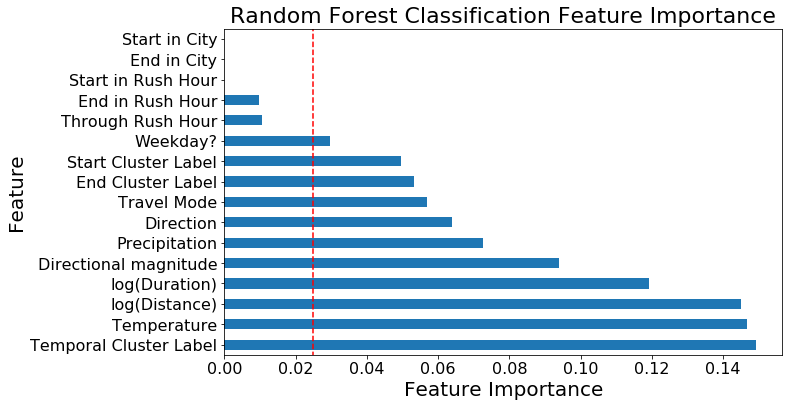

In [78]:
feat_imps_current = ["Temporal Cluster Label","Temperature",'log(Distance)', 'log(Duration)',\
                     'Directional magnitude', "Precipitation",'Direction', 'Travel Mode', 'End Cluster Label',\
                     'Start Cluster Label', 'Weekday?','Through Rush Hour', 'End in Rush Hour',\
                     'Start in Rush Hour', 'End in City', 'Start in City']
fig, ax = plt.subplots(1, figsize=(10,6))
feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
feat_imp.plot(kind='barh', ax=ax, legend=False)
# ax.set_yticklabels(list(feat_imp.importance.values), size=16);
ax.set_yticklabels(feat_imps_current, size=16);
plt.xticks(size=16);
plt.xlabel("Feature Importance", size=20)
plt.ylabel("Feature", size=20)
plt.title("Random Forest Classification Feature Importance", size=22)
plt.vlines(0.025,-10,50, color='r', linestyles='--')
# plt.savefig("figures/rf_classification_imp_2fi.png", bbox_inches='tight')

In [676]:
feature_importances[:7]

[('temporal_c', 0.22405),
 ('temperatur', 0.11788),
 ('log_dist', 0.10879),
 ('log_dur', 0.10442),
 ('magnitude', 0.10411),
 ('precip', 0.06783),
 ('carddir', 0.06369)]

## re-subset

In [285]:
X = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir"]]
y = data[["purpose_labels"]]

In [286]:
data = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir", "purpose_labels"]]
X = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip","carddir"]]
y = data[["purpose_labels"]]

## One Hot Encoding

In [362]:
enc = OneHotEncoder(handle_unknown='ignore')

# mode_codes = enc.fit_transform(data['mode'].values.reshape(-1, 1)).toarray()
carddir_codes = enc.fit_transform(data['carddir'].values.reshape(-1, 1)).toarray()
# stcl_codes = enc.fit_transform(data['startclust'].values.reshape(-1, 1)).toarray()
# encl_codes = enc.fit_transform(data['endclust'].values.reshape(-1, 1)).toarray()
# sthr_codes = enc.fit_transform(data['starthour'].values.reshape(-1, 1)).toarray()
# enhr_codes = enc.fit_transform(data['endhour'].values.reshape(-1, 1)).toarray()
y_codes = enc.fit_transform(data['purpose_labels'].values.reshape(-1, 1)).toarray()

In [363]:
data['purpose_labels'].value_counts()

1    47464
5    18950
2     2769
4     1574
3     1044
Name: purpose_labels, dtype: int64

In [364]:
non_codes = data[["temporal_c","temperatur","log_dist","log_dur","magnitude","precip"]] # without carddir
# non_codes['weekday'] = non_codes['weekday'].astype(int)
feature_list = list(non_codes)
non_codes = non_codes.values
non_codes = non_codes / np.amax(non_codes, axis=0)

In [365]:
all_input = np.concatenate((non_codes,carddir_codes), axis=1) # mode_codes stcl_codes encl_codes sthr_codes enhr_codes

In [375]:
all_input.shape

(71801, 22)

In [367]:
y_codes.shape

(71801, 5)

In [368]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(all_input, y_codes, test_size=0.33, random_state=42)

## Multi-Class Random Forest:

In [836]:
%%time 
# Random forest classifier

# clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
multi_target_forest = MultiOutputClassifier(clf, n_jobs=-1)

CPU times: user 46 µs, sys: 1e+03 ns, total: 47 µs
Wall time: 53.2 µs


In [837]:
print(X_train.shape)
print(y_train.shape)

(48106, 22)
(48106, 5)


In [838]:
multi_target_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=10,
                                                       n_jobs=None,
                  

In [839]:
multi_target_forest.score(X_test, y_test)

0.7372863473306605

In [842]:
res = pd.DataFrame(multi_target_forest.predict(X_test), columns=np.arange(1,6))

In [843]:
res.head()

,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [844]:
# predictions of 1, predictions of 0 and predictions of 2
res.sum(axis=1).value_counts()

1.0    21149
0.0     2369
2.0      177
dtype: int64

In [845]:
res.sum()

1    16576.0
2       13.0
3        0.0
4        1.0
5     4913.0
dtype: float64

In [846]:
def check_accuracy(pred, original):
    vals = []
    for i in range(len(pred)):
        if sum(pred[i]) == 1:
            if np.where(original[i])[0][0] == np.where(pred[i])[0][0]:
                vals.append(True)
            else:
                vals.append(False)
            
            
        elif sum(pred[i]) == 0:
            vals.append("No pred")
        else:
            vals.append(False)
    return vals

In [847]:
pred_res = pd.DataFrame(y_test, columns=np.arange(1,6))
pred_res['res'] = check_accuracy(multi_target_forest.predict(X_test), y_test)

In [848]:
pred_res.head()

,1,2,3,4,5,res
0,1.0,0.0,0.0,0.0,0.0,True
1,0.0,0.0,1.0,0.0,0.0,False
2,1.0,0.0,0.0,0.0,0.0,True
3,1.0,0.0,0.0,0.0,0.0,True
4,1.0,0.0,0.0,0.0,0.0,True


In [849]:
y_test

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [850]:
no_vals

{1: 1092, 2: 177, 3: 56, 4: 51, 5: 993}

In [857]:
wrong_vals = {}
no_vals = {}
total_vals = {}
for col in pred_res.columns[:-1]:
    wrong_vals[col] = pred_res.loc[pred_res[col] == 1.0].res.value_counts()
    wrong_vals[col] = len(pred_res.loc[(pred_res[col] == 1.0) &(pred_res.res == False)])
    no_vals[col] = pred_res.loc[pred_res[col] == 1.0].res.value_counts()['No pred']
    total_vals[col] = pred_res[col].sum()
    print(col,":\n", pred_res.loc[pred_res[col] == 1.0].res.value_counts(), "\n")

1 :
 True       13886
No pred     1092
False        683
Name: res, dtype: int64 

2 :
 False      777
No pred    177
True         1
Name: res, dtype: int64 

3 :
 False      266
No pred     56
Name: res, dtype: int64 

4 :
 False      458
No pred     51
True         1
Name: res, dtype: int64 

5 :
 True       3582
False      1672
No pred     993
Name: res, dtype: int64 



In [858]:
wrong_vals,total_vals, no_vals

({1: 683, 2: 777, 3: 266, 4: 458, 5: 1672},
 {1: 15661.0, 2: 955.0, 3: 322.0, 4: 510.0, 5: 6247.0},
 {1: 1092, 2: 177, 3: 56, 4: 51, 5: 993})

In [859]:
# purpose_counts = gdf.purpose_labels.value_counts().to_dict() 

In [860]:
correct_perc = {}
for col in pred_res.columns[:-1]:
    correct_perc[str(col)] = ((total_vals[col] - wrong_vals[col] - no_vals[col]) / (total_vals[col] - no_vals[col]))*100

In [861]:
correct_perc

{'1': 95.31196375866567,
 '2': 0.12853470437017994,
 '3': 0.0,
 '4': 0.2178649237472767,
 '5': 68.1766273315569}

## Support Vector Classification/Regression?

In [370]:
# y_factorised = purpose_factorise[0]
y_svc = y.values
X_train, X_test, y_train, y_test = train_test_split(all_input, y_svc, test_size=0.33, random_state=42)

In [371]:
%%time
clf = svm.SVC(gamma='scale', decision_function_shape='ova')
clf.fit(X_train, y_train)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [880]:
clf.decision_function

<bound method BaseSVC.decision_function of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>

In [881]:
clf.score(X_test, y_test)

0.7471196454948301

In [882]:
svm_preds = clf.predict(X_test)  
len(svm_preds)

23695

In [893]:
pd.DataFrame(y_test, svm_preds.reshape(-1,1))

,0
"(1,)",1
"(5,)",3
"(1,)",1
"(1,)",1
"(1,)",1
"(1,)",1
"(5,)",5
"(5,)",5
"(1,)",1
"(1,)",1


In [888]:
svm_pred_df = pd.DataFrame([y_test, svm_preds]).T
svm_pred_df.columns = ['actual', 'svm_preds']

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [884]:
svm_pred_df.actual.value_counts()

[[1], [3], [1], [1], [1], [1], [5], [5], [1], [1], [1], [1], [2], [4], [1], [1], [1], [5], [5], [1], [5], [5], [5], [1], [1], [5], [2], [1], [5], [5], [5], [5], [1], [5], [1], [5], [5], [5], [5], [5], [1], [5], [1], [5], [5], [1], [5], [1], [5], [1], [1], [1], [1], [1], [1], [5], [1], [5], [1], [1], [5], [1], [1], [1], [1], [5], [1], [1], [1], [1], [1], [5], [1], [1], [1], [5], [1], [5], [1], [1], [5], [5], [1], [1], [1], [5], [1], [5], [1], [5], [1], [1], [1], [1], [1], [5], [1], [5], [5], [1], ...]    1
Name: actual, dtype: int64

In [885]:
svm_pred_df.svm_preds.value_counts()

[1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 5, 5, 1, 5, 1, 1, 1, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, ...]    1
Name: svm_preds, dtype: int64

In [886]:
svm_pred_df.head()

,actual,svm_preds
0,"[[1], [3], [1], [1], [1], [1], [5], [5], [1], ...","[1, 5, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 5, 1, 1, ..."


In [78]:
svm_pred_df.loc[svm_pred_df.actual == svm_pred_df.svm_preds]['actual'].value_counts()

3    7745
1    5192
2     521
5     190
Name: actual, dtype: int64

In [ ]:
svm_pred_df.loc[svm_pred_df.actual == svm_pred_df.svm_preds]['actual'].value_counts()

## Grid-Search

In [379]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 1, 10]
    gammas = [0.01, 0.1, 1]
    decision_function_shapes = ['ova','ovo']
    param_grid = {'C': Cs, 'gamma' : gammas, "decision_function_shape":decision_function_shapes}
    
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [296]:
clf, feature_list, _ = run_rf(purp_gdf, norm=False, cv=False);
feature_importances, above_005 = calc_feature_imp(clf, feature_list);
data = subset_to_imp_features(df, above_005)
all_inputs, y_codes = encode_inputs(data)
y_single = np.array([np.where(val)[0]+1 for val in y_codes]) # for svc and nn which dont do multiclass

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Score: 0.8114792150242667


In [380]:
%%time
best_params = svc_param_selection(all_input, y_svc, 3)
best_params

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

CPU times: user 15min 1s, sys: 17.7 s, total: 15min 19s
Wall time: 15min 53s


{'C': 0.1, 'decision_function_shape': 'ova', 'gamma': 0.01}

In [300]:
best_params

{'C': 0.1, 'gamma': 0.01}

0.1

In [320]:
parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500],\
              'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':[(50,50,50), (5,10,5), (100,)]}
clf_grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

In [376]:
%%time
clf_grid.fit(all_inputs, y_codes)

NameError: name 'clf_grid' is not defined

In [323]:
clf_grid.best_params_

{'alpha': 0.01,
 'hidden_layer_sizes': (50, 50, 50),
 'max_iter': 500,
 'solver': 'lbfgs'}

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.05],
}
# MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [312]:
%%time
mlp = MLPClassifier(max_iter=100)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)

CPU times: user 7.77 s, sys: 720 ms, total: 8.49 s
Wall time: 4min 6s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...one, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [1e-05, 0.0

In [313]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'adam'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'adam'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50, 100, 50), 'solver': 'lbfgs'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.759 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (100,), 

In [ ]:
y_true, y_pred = DEAP_y_test , clf.predict(DEAP_x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

## ANN

In [97]:
import numpy as np

dims_of_x = len(all_inputs[0])

class NeuralNetwork():
    
    def __init__(self, dims_of_x):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 4 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((dims_of_x, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, inputs):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        inputs = inputs.astype(float)
        output = self.sigmoid(np.dot(inputs, self.synaptic_weights))
        return output

In [98]:
X_train, X_test, y_train, y_test = train_test_split(all_inputs, y_codes, test_size=0.33, random_state=42)
y_single_train = np.array([np.where(val)[0]+1 for val in y_train]) # for svc and nn which dont do multiclass
y_single_test = np.array([np.where(val)[0]+1 for val in y_test]) # for svc and nn which dont do multiclas

array([0.78268551, 0.6469182 , 0.79711049, 0.79856564, 0.80334685])

In [99]:
%%time
#initializing the neuron class
neural_network = NeuralNetwork(dims_of_x=len(all_inputs[0]))

print("Beginning Randomly Generated Weights: ")
print(neural_network.synaptic_weights)

#training data consisting of 4 examples--3 input values and 1 output
training_inputs = X_train

training_outputs = y_single_train

#training taking place
neural_network.train(training_inputs, training_outputs, 10000)

print("Ending Weights After Training: ")
print(neural_network.synaptic_weights)

Beginning Randomly Generated Weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]
 [-0.39533485]
 [-0.70648822]
 [-0.81532281]
 [-0.62747958]
 [-0.30887855]
 [-0.20646505]
 [ 0.07763347]
 [-0.16161097]
 [ 0.370439  ]
 [-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]
 [-0.1653904 ]
 [ 0.11737966]
 [-0.71922612]
 [-0.60379702]
 [ 0.60148914]
 [ 0.93652315]]
Ending Weights After Training: 
[[ 7384.85666521]
 [ 8327.82968914]
 [  525.94367917]
 [ 7552.32498236]
 [11817.40687665]
 [10861.58048211]
 [  549.36033273]
 [ 1099.5872206 ]
 [ 1637.14259492]
 [  777.21204784]
 [ 1095.43110865]
 [  942.16681436]
 [ 1024.39671005]
 [  996.60291997]
 [  585.37636584]
 [  877.86798257]
 [  929.31060692]
 [  959.30870873]
 [  576.94850629]
 [  660.79817919]
 [ 1458.51753601]
 [ 1274.03070634]]
CPU times: user 3min 17s, sys: 25.5 s, total: 3min 43s
Wall time: 2min 6s


In [104]:
all_inputs

array([[0.60817148, 0.2       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.46482825, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24388107, 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.47746443, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ],
       [0.99960312, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ],
       [0.67953078, 0.2       , 0.00245678, ..., 0.        , 0.        ,
        0.        ]])

In [105]:
import collections

In [110]:
neural_network.think(X_test)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
# test_data["round_preds"] = test_data.preds.apply(lambda pred: round(pred))

## over sampling

In [96]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

In [97]:
ros

RandomOverSampler(random_state=0, ratio=None, return_indices=False,
                  sampling_strategy='auto')

In [99]:
X_resampled, y_resampled = ros.fit_resample(all_input, y_factorised)

In [102]:
len(all_input)

74218

In [101]:
len(X_resampled)

271280

In [104]:
len(y_factorised)

74218

In [105]:
len(y_resampled)

271280

In [116]:
y_resampled

array([0, 1, 1, ..., 9, 9, 9])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

In [ ]:
%%time
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)

In [ ]:
svm_preds = clf.predict(X_test)  

In [ ]:
clf.score(X_test, y_test)